# Classification of email spam

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.io as sio
import time
data = sio.loadmat('spamData.mat')

## Adaboost

In [2]:
def accuracy(predicted_result, actual_result):
    diff = predicted_result - actual_result
    return 1.0 - (float(np.count_nonzero(diff)) / len(diff))

In [3]:
def decesion_stumps(X,y,D):
    # Here the decesion stump is for x_i>b, different from textbook!
    n_samples, n_features =X.shape
    F_ast = float('inf')
    for j in range(n_features):
        feature_values = X[:, j]
        # dict ={feature_values[i]:(y[i], D[i]) for i in range(n_samples)}
        sorted_features = sorted([(feature_i, y_i, D_i) for feature_i, y_i, D_i in \
                                  zip(feature_values, y, D)])
        F = np.sum(D*((-y+1)/2), axis =0,  keepdims = False) # different from textbook!

        if F<F_ast:
            F_ast = F.copy()
            theta = sorted_features[0][0] - 1
            j_ast = j
        for i in range(len(sorted_features)-1):

            feature_i, y_i ,D_i =sorted_features[i]

            F += (-D_i if y_i==-1 else D_i) # different from textbook!
            if F < F_ast and (feature_i != sorted_features[i+1][0]):
                F_ast =F.copy()
                theta = 0.5 *(feature_i + sorted_features[i+1][0])
                j_ast = j
    
    return j_ast, theta

In [4]:
def adaboost(Xtrain,ytrain,Xtest,ytest, T):
    n_samples, n_features =Xtrain.shape
    n_samples_test, n_features = Xtest.shape
    adaboost_train = []
    adaboost_test =  []
    weights = []
    err_train = []
    err_test = []

    D = 1.0/n_samples * np.ones([n_samples,1])
    for t in range(T):
        j, theta = decesion_stumps(Xtrain,ytrain,D)
        # print("theta = {}".format(theta))
        # print("j = {}".format(j))
        wl_train = list(map(lambda x: 1 if x > theta else -1 , Xtrain[:, j]))
        adaboost_train.append(wl_train)
    
        wl_test = list(map(lambda x: 1 if x > theta else -1, Xtest[:, j]))
        adaboost_test.append(wl_test)
        mistakes_train = [ 0 if wl_train[i] == ytrain[i] else 1 for i in range(len(ytrain))]
        eps = np.sum(D*(np.array(mistakes_train).reshape([n_samples,1])) )
        w = 0.5*np.log(1.0/eps-1)
        weights = np.append(weights, w)
        test = -w*ytrain*np.array(wl_train).reshape(n_samples,1)
        D = D *np.exp(-w*ytrain*np.array(wl_train).reshape(n_samples,1))
        D/= np.sum(D, keepdims=False)
        if (t%100 == 0):
           
            predict_train = np.sign(np.sum(np.array(adaboost_train)* \
                                           (np.array(weights).reshape([len(weights),1])) ,\
                                           axis =0)).reshape([n_samples,1])

          
            err_train.append(1.0 - accuracy(predict_train, ytrain))
            predict_test = np.sign(np.sum(np.array(adaboost_test)* \
                                          (np.array(weights).reshape([len(weights),1])) , \
                                          axis =0)).reshape([ n_samples_test, 1])
            err_test.append(1.0 - accuracy(predict_test, ytest))
            print("iter: {}, training misclassification: {}".format(str(t), err_train[-1]))
            print("iter: {}, test misclassification: {}".format(str(t), err_test[-1]))
            print("theta = {}".format(theta))
            print("j = {}".format(j))
            print("w = {}".format(w))
    return err_train, err_test

In [5]:
Xtrain = data['Xtrain']
ytrain = data['ytrain']
Xtest = data['Xtest']
ytest = data['ytest']

ytrain = np.int8(ytrain)*2-1
ytest = np.int8(ytest)*2-1
time_start = time.clock()
err_train, err_test = adaboost(Xtrain,ytrain,Xtest,ytest, T=1000)
time_adaboost = (time.clock() - time_start)
print("Training elasped time = {}".format(time_adaboost))

/Users/xueying/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


iter: 0, training misclassification: 0.20130505709624802
iter: 0, test misclassification: 0.21419270833333337
theta = 0.0455
j = 52
w = 0.6890788098634144
iter: 100, training misclassification: 0.100489396411093
iter: 100, test misclassification: 0.10611979166666663
theta = 1.5
j = 56
w = 0.028282006745164026
iter: 200, training misclassification: 0.09755301794453508
iter: 200, test misclassification: 0.103515625
theta = 1.5
j = 56
w = 0.020345220407118617
iter: 300, training misclassification: 0.09168026101141924
iter: 300, test misclassification: 0.10416666666666663
theta = 1.5
j = 56
w = 0.015956185505731284
iter: 400, training misclassification: 0.0907014681892333
iter: 400, test misclassification: 0.1015625
theta = 1.5
j = 56
w = 0.013653288687828469
iter: 500, training misclassification: 0.08711256117455135
iter: 500, test misclassification: 0.09765625
theta = 1.5
j = 56
w = 0.011818891679444658
iter: 600, training misclassification: 0.08613376835236541
iter: 600, test misclassif

/Users/xueying/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


## Logistic Regression

In [6]:
def logreg_loss(w, X, y):
    [m,n]=X.shape
    loss = np.sum(np.log(np.exp(- np.dot(X,w)*y)+1))/m
    return loss

In [7]:
def logreg_grad(w, X, y):
    [m,n]=X.shape
    numerator = X*y
    denominator = np.exp(np.dot(X,w)*y)+1
    #print(denominator)
    grad = - np.sum(numerator/denominator, axis = 0)/m
    grad.reshape((n,1))
    return grad.reshape((n,1))

In [8]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))

In [9]:
def predict(X, w):
    z = np.dot(X, w)
    return sigmoid(z)

In [10]:
def accuracy(predicted_result, actual_result):
    diff = predicted_result - actual_result
    return 1.0 - (float(np.count_nonzero(diff)) / len(diff))

In [11]:
def classify(predictions):
    return np.vectorize(lambda prob: 1 if prob >= .5 else -1)(predictions)

In [12]:
def misclassification(w, X, y):
    [m,n]=X.shape
    prediction = predict(X, w)
    results = classify(prediction)
    return 1 - accuracy(results, y)

In [13]:
def logistic_regression(Xtrain, ytrain, Xtest, ytest, T, eta):
    [m,n] =Xtrain.shape
    w =np.zeros((n,1))
    mis_train =[]
    mis_test =[]
    for t in range(T):
        grad = logreg_grad(w, Xtrain, ytrain)
        #print(grad)
        w = w - eta*grad
        if (t%100 == 0):
            mis_train.append(misclassification(w, Xtrain, ytrain))
            mis_test.append(misclassification(w, Xtest, ytest))
            print("iter: {}, training misclassification: {}".format(str(t), mis_train[-1]))
            print("iter: {}, test misclassification: {}".format(str(t), mis_test[-1]))
    return mis_train, mis_test

In [14]:
Xtrain = data['Xtrain']
ytrain = data['ytrain']
Xtest = data['Xtest']
ytest = data['ytest']
Xtrain = np.log(Xtrain +0.1)
Xtest = np.log(Xtest +0.1)
ytrain = np.int8(ytrain)*2-1
ytest = np.int8(ytest)*2-1
[mtrain, n] = Xtrain.shape
[mtest, n]= Xtest.shape
Xtrain = np.insert(Xtrain,[0], np.ones((mtrain,1)),axis = 1)
Xtest = np.insert(Xtest,[0], np.ones((mtest,1)),axis = 1)
time_start = time.perf_counter()
mis_train,mis_test = logistic_regression(Xtrain, ytrain, Xtest, ytest, 1000, 0.01)
time_logreg = (time.perf_counter() - time_start)
print("Training elasped time = {}".format(time_logreg))

/Users/xueying/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


iter: 0, training misclassification: 0.397389885807504
iter: 0, test misclassification: 0.38736979166666674
iter: 100, training misclassification: 0.10244698205546499
iter: 100, test misclassification: 0.115234375
iter: 200, training misclassification: 0.09461663947797716
iter: 200, test misclassification: 0.10546875
iter: 300, training misclassification: 0.08874388254486132
iter: 300, test misclassification: 0.09830729166666663
iter: 400, training misclassification: 0.08482871125611746
iter: 400, test misclassification: 0.095703125
iter: 500, training misclassification: 0.08156606851549753
iter: 500, test misclassification: 0.09505208333333337
iter: 600, training misclassification: 0.07960848287112565
iter: 600, test misclassification: 0.09244791666666663
iter: 700, training misclassification: 0.07667210440456773
iter: 700, test misclassification: 0.087890625
iter: 800, training misclassification: 0.07275693311582376
iter: 800, test misclassification: 0.08268229166666663
iter: 900, tr

/Users/xueying/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


# Results comparison

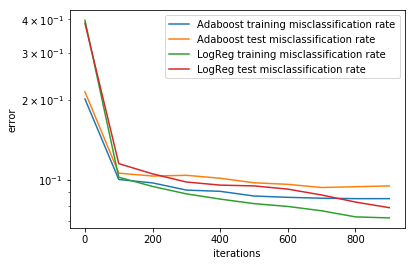

In [15]:
%matplotlib inline
fig=plt.figure()
plt.semilogy([100*t for t in range(10)], err_train, label='Adaboost training misclassification rate')
plt.semilogy([100*t for t in range(10)], err_test,  label='Adaboost test misclassification rate')
plt.semilogy([100*t for t in range(10)], mis_train, label='LogReg training misclassification rate')
plt.semilogy([100*t for t in range(10)], mis_test,  label='LogReg test misclassification rate')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

The training of Adaboost with 1000 iterations took 2169s, while training with Logistic Regresison only took 1.28s. Logistic regression also achieve better accuracy on both training and testing data sets. Further study on how to speedup Adaboost, and improve its convergence are interesting to investigate.